# DenseNet201 Transfer Learning for Skin Cancer Classification

## 1. Installing Dependencies

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201,VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers

In [2]:
# For using GPUS
gpus = tf.config.experimental.list_physical_devices('GPU') # Listing GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## 2. Data Preparation & Augmentation

In [3]:
# Define class names and labels
class_names = ["benign","malignant"]
class_labels = {class_name: i for i, class_name in enumerate(class_names)}

# Define image and batch size
image_size = (224, 224)  # Changed to match DenseNet201 input size
batch_size = 32

In [4]:
# Data augmentation and preprocessing

train_data_dir = "Data/Train"
validate_data_dir = "Data/Validate"
test_data_dir = "Data/Test"  # Updated path to the testing folder

# Data augmentation and preprocessing
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'    
)

# Training data generator
train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    classes=class_names,
    shuffle=True
)

# Data preprocessing for validation (no augmentation)
validation_data_gen = ImageDataGenerator(rescale=1.0 / 255)

# Validation data generator
validation_generator = validation_data_gen.flow_from_directory(
    validate_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=class_names
)

# Output should be 
#Found 7000 images belonging to 2 classes.  # Train data set
#Found 2001 images belonging to 2 classes.  # Validate data set

Found 7000 images belonging to 2 classes.
Found 2001 images belonging to 2 classes.


In [5]:
# data_iterator = train_generator.as_numpy_iterator()

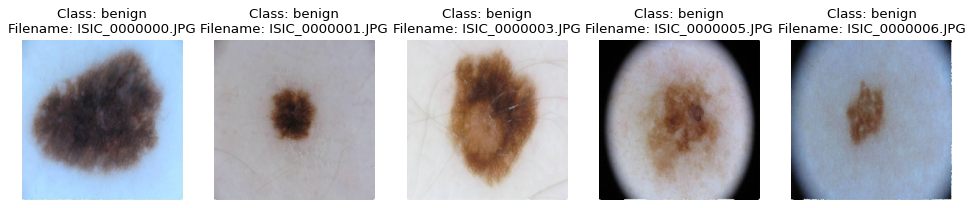

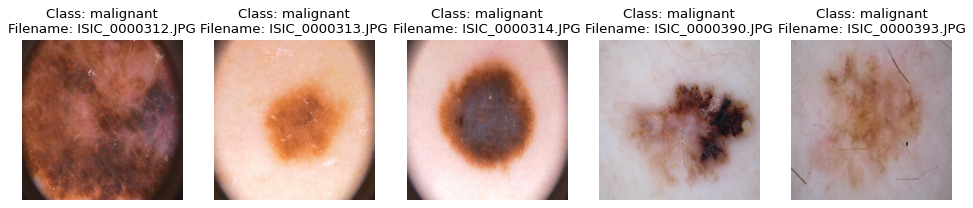

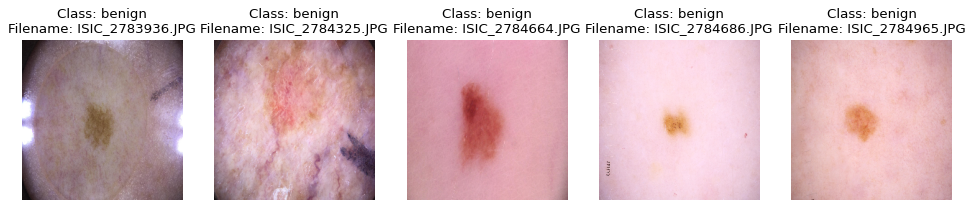

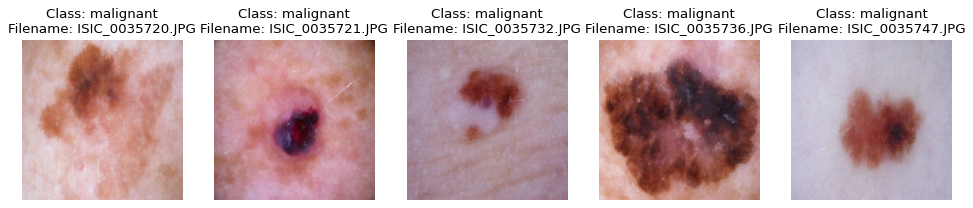

In [6]:
# Display images and their classes for Manual Checking
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to load and display images
def load_and_display_images(directory, class_name, num_images=5):
    # Get a list of image files from the specified directory
    image_files = glob.glob(os.path.join(directory, class_name, '*.jpg'))
    
    # Check if there are any image files
    if not image_files:
        print(f"No image files found for class {class_name} in directory {directory}")
        return

    # Display a grid of images with their labels and filenames
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5), dpi=80)
    for i in range(min(num_images, len(image_files))):
        # Load the image
        img_path = image_files[i]
        img = image.load_img(img_path, target_size=image_size)

        # Display the image along with its class label and filename
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_name}\nFilename: {os.path.basename(img_path)}")
        axes[i].axis('off')

    plt.show()

# Specify the directories and class names
train_data_dir = "Data/Train"
validate_data_dir = "Data/Validate"

# Display images from the training set
for class_name in class_names:
    load_and_display_images(train_data_dir, class_name)

# Display images from the validation set
for class_name in class_names:
    load_and_display_images(validate_data_dir, class_name)

## 3. Building the Model

In [7]:
# Function for calculating Learning Rate with help of epoch
def lr_scheduler(epoch):
    return 0.00001

In [8]:
model = Sequential()

In [9]:
# Build and compile the model (DenseNet201)
# To change your Model to any other model import model at Section 1 and Change the name here
# You need to check input image size also , for DenseNet201 it is 224x224
# e.g base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Changed to Global Average Pooling intead of Flatten()
    keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [10]:
# Optimizers are used to minimize the loss function by updating the model parameters(weights and biases) during training 
# Using binary crossentropy as we are doing Binary Classification
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy']) 
# model.compile(optimizer=SGD(learning_rate=0.001), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # --> Apply this if Overfitting
# lr_callback = LearningRateScheduler(lr_scheduler)

In [11]:
# Train the model with early stopping
# * monitor='val_loss': It monitors the validation loss during training.
# * patience=5 : Training will stop if the validation loss does not improve for 5 consecutive epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18,814,017
Trainable params: 492,033
Non-trainable params: 18,321,984
____________________________________

## 4. Training the Model

In [13]:
logdir = "logs"

In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [15]:
hist = model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[tensorboard_callback,early_stopping]) 

Epoch 1/40
219/219 [==============================] - 251s 1s/step - loss: 2.7058 - accuracy: 0.7146 - val_loss: 0.9457 - val_accuracy: 0.7561
Epoch 2/40
219/219 [==============================] - 215s 981ms/step - loss: 0.8720 - accuracy: 0.7400 - val_loss: 0.8426 - val_accuracy: 0.7121
Epoch 3/40
219/219 [==============================] - 16145s 74s/step - loss: 0.7770 - accuracy: 0.7424 - val_loss: 0.7006 - val_accuracy: 0.7731
Epoch 4/40
219/219 [==============================] - 217s 990ms/step - loss: 0.7381 - accuracy: 0.7510 - val_loss: 0.8028 - val_accuracy: 0.6977
Epoch 5/40
219/219 [==============================] - 217s 990ms/step - loss: 0.7105 - accuracy: 0.7601 - val_loss: 0.6773 - val_accuracy: 0.7671
Epoch 6/40
219/219 [==============================] - 216s 984ms/step - loss: 0.7075 - accuracy: 0.7580 - val_loss: 0.7627 - val_accuracy: 0.7306
Epoch 7/40
219/219 [==============================] - 212s 966ms/step - loss: 0.7120 - accuracy: 0.7540 - val_loss: 0.6949 - va

In [16]:
# Saving the Model for later usage !!! Change to different name to Save your Model !!!
model.save(os.path.join('models','densenet201.keras'))

## 5. Plotting Performance

In [17]:
import matplotlib.pyplot as plt

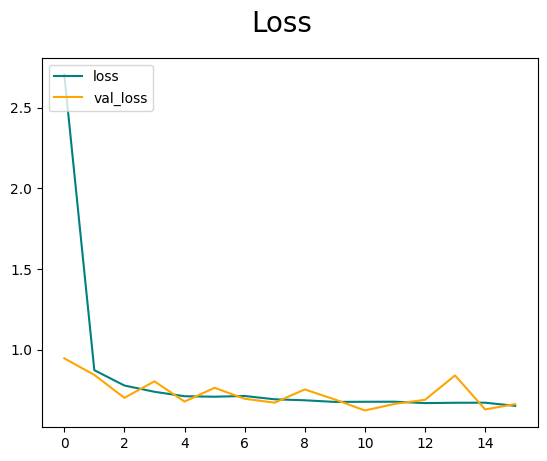

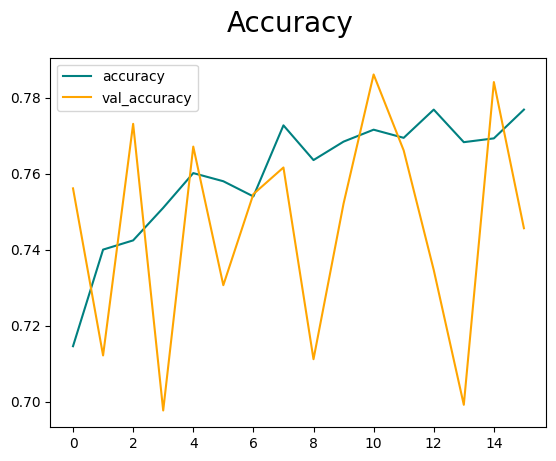

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 6. Performance Evaluation


In [19]:
# Load the trained model for testing
model = keras.models.load_model(os.path.join("models","densenet201.keras"))

In [20]:
# Prepare the test data
test_data_gen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 999 images belonging to 2 classes.


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

# Make predictions on test data
test_predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = [class_names[i] for i in np.argmax(test_predictions, axis=1)]

# Prepare true labels
y_true_list = test_generator.classes

# Convert predictions to binary labels using a threshold (e.g., 0.5)
y_pred_list = (test_predictions > 0.5).astype(int)

# Print classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_list, y_pred_list))
print("\nClassification Report:")
print(classification_report(y_true_list, y_pred_list, target_names=class_names))

999/999 [==============================] - 49s 48ms/step
Confusion Matrix:
[[462  38]
 [249 250]]

Classification Report:
              precision    recall  f1-score   support

      benign       0.65      0.92      0.76       500
   malignant       0.87      0.50      0.64       499

    accuracy                           0.71       999
   macro avg       0.76      0.71      0.70       999
weighted avg       0.76      0.71      0.70       999



In [22]:
# Calculate and print precision, recall, and accuracy
precision = precision_score(y_true_list, y_pred_list, average='binary')
recall = recall_score(y_true_list, y_pred_list, average='binary')
accuracy = accuracy_score(y_true_list, y_pred_list)

print(f'Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}')

Precision: 0.8680555555555556, Recall: 0.501002004008016, Accuracy: 0.7127127127127127


## 7. Testing the Model

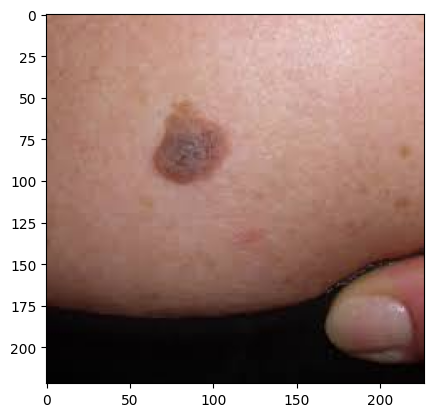

In [27]:
img = cv2.imread('Testing/benign.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

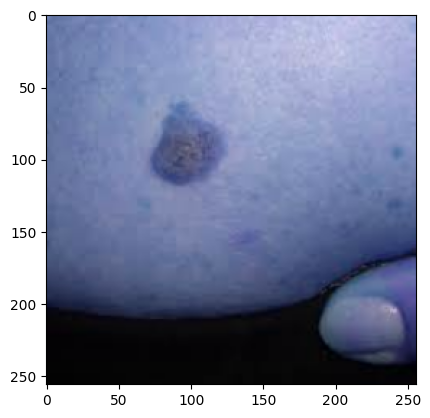

In [28]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
yhat = model.predict(np.expand_dims(resize/255 , 0))

1/1 [==============================] - 0s 43ms/step


In [30]:
if yhat > 0.5 :
    print(f'Malignant')
elif yhat < 0.5 :
    print(f'Benign')

Benign
